In [1]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd
import sys
import networkx as nx
import os
import warnings
# matplotlib and seaborn for plotting

import matplotlib.pyplot as plt
import seaborn as sns

import os

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
ROOT_PACKAGE_DIRECTORY = '/Users/bede01/Documents/work/phd-papers/ml-workload-optimization/code/jupyter'
ROOT_DATA_DIRECTORY = ROOT_PACKAGE_DIRECTORY + '/data'
GRAPH_DATABASE_PATH = ROOT_PACKAGE_DIRECTORY + '/data/graph/exp-reuse-same-workload.graph'
sys.path.append(ROOT_PACKAGE_DIRECTORY)

# Experiment Graph
from experiment_graph.execution_environment import ExecutionEnvironment


# Suppress warnings
warnings.filterwarnings('ignore')
% matplotlib inline


try:
    import pygraphviz
    from networkx.drawing.nx_agraph import graphviz_layout
except ImportError:
    try:
        import pydot
        from networkx.drawing.nx_pydot import graphviz_layout
    except ImportError:
        raise ImportError("This example needs Graphviz and either "
                          "PyGraphviz or pydot")

In [2]:
import os
import sys
import warnings
import hashlib

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from importlib import import_module


In [3]:
root_data = ROOT_PACKAGE_DIRECTORY + '/data'
DATABASE_PATH = ROOT_PACKAGE_DIRECTORY + '/data/environment_same_workload'
execution_environment = ExecutionEnvironment()

['.DS_Store', 'openml', 'home-credit-default-risk', 'experiment_graphs']
('Training data shape: ', (307511, 122))
('Testing data shape: ', (48744, 121))
Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


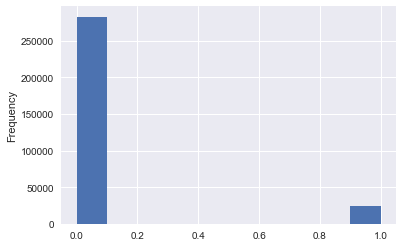

In [4]:
print(os.listdir(root_data))
app_train = execution_environment.load(root_data + '/home-credit-default-risk/application_train.csv')
print('Training data shape: ', app_train.shape().data())
app_train.head().data()

app_test = execution_environment.load(root_data + '/home-credit-default-risk/application_test.csv')
print('Testing data shape: ', app_test.shape().data())
app_test.head().data()

app_train['TARGET'].value_counts().data()

app_train['TARGET'].data().astype(int).plot.hist()

# Function to calculate missing values by column# Funct
def missing_values_table(dataset):
    # Total missing values
    mis_val = dataset.isnull().sum().data()

    mis_val_percent = 100 * mis_val / len(dataset.data())

    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(columns={
        0: 'Missing Values',
        1: '% of Total Values'
    })
    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:, 1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)

    # Print some summary information
    print("Your selected dataframe has " + str(dataset.shape().data()[1]) + " columns.\n"
                                                                            "There are " + str(
        mis_val_table_ren_columns.shape[0]) +
          " columns that have missing values.")

    # Return the dataframe with missing information
    return mis_val_table_ren_columns

missing_values = missing_values_table(app_train)
missing_values.head(20)

In [5]:
app_train.dtypes().data().value_counts()

app_train.select_dtypes('object').nunique().data()

from sklearn_helper.sklearn_connectors import LabelEncoder
# Create a label encoder object
le = LabelEncoder()
le_count = 0

for col in app_train.select_dtypes('object').data().columns:
    # we are not using nunique because it discard nan
    if app_train[col].nunique(dropna=False).data() <= 2:
        le.fit(app_train[col])
        app_train = app_train.replace_columns(col, le.transform(app_train[col]))
        app_test = app_test.replace_columns(col, le.transform(app_test[col]))

        # Keep track of how many columns were label encoded
        le_count += 1
print('%d columns were label encoded.' % le_count)

3 columns were label encoded.


In [6]:
optimized = app_train.data()[['NAME_CONTRACT_TYPE','FLAG_OWN_CAR','FLAG_OWN_REALTY']]

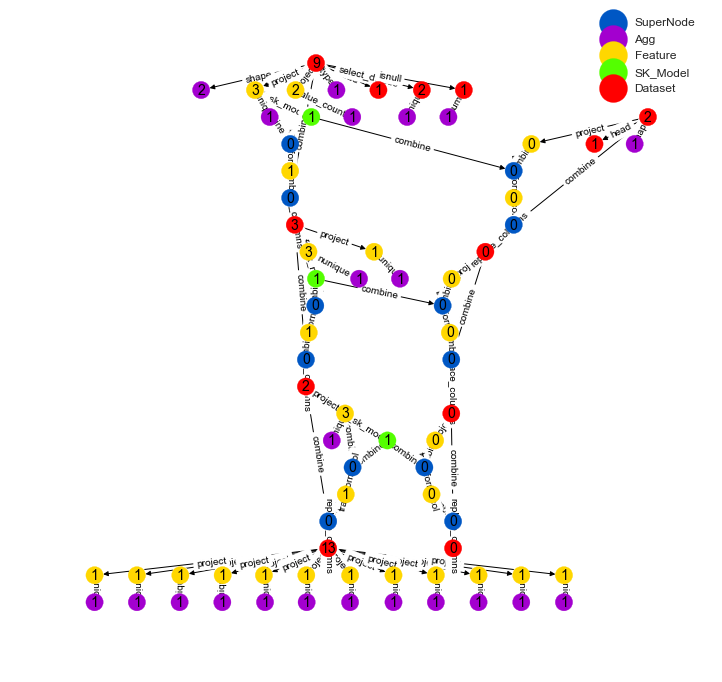

In [7]:
execution_environment.graph.plot_graph(plt, vertex_freq=True, edge_oper=True, edge_time=False)

['.DS_Store', 'openml', 'home-credit-default-risk', 'experiment_graphs']
('Training data shape: ', (307511, 122))
('Testing data shape: ', (48744, 121))
Your selected dataframe has 122 columns.
There are 67 columns that have missing values.
3 columns were label encoded.


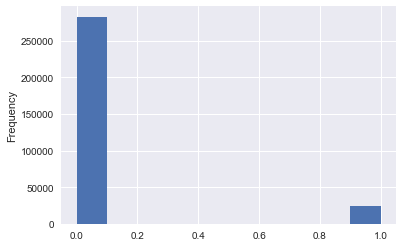

In [8]:
print(os.listdir(root_data))
app_train = pd.read_csv(root_data + '/home-credit-default-risk/application_train.csv')
print('Training data shape: ', app_train.shape)
app_train.head()

app_test = pd.read_csv(root_data + '/home-credit-default-risk/application_test.csv')
print('Testing data shape: ', app_test.shape)
app_test.head()

app_train['TARGET'].value_counts()

app_train['TARGET'].astype(int).plot.hist()

# Function to calculate missing values by column# Funct
def missing_values_table(df):
    # Total missing values
    mis_val = df.isnull().sum()

    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)

    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(columns={
        0: 'Missing Values',
        1: '% of Total Values'
    })

    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:, 1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)

    # Print some summary information
    print("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
                                                              "There are " + str(
        mis_val_table_ren_columns.shape[0]) +
          " columns that have missing values.")

    # Return the dataframe with missing information
    return mis_val_table_ren_columns

missing_values = missing_values_table(app_train)
missing_values.head(20)

app_train.dtypes.value_counts()

app_train.select_dtypes('object').apply(pd.Series.nunique, axis=0)
from sklearn.preprocessing import LabelEncoder
# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in app_train:
    if app_train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(app_train[col].unique())) <= 2:
            # Train on the training data
            le.fit(app_train[col])
            # Transform both training and testing data
            app_train[col] = le.transform(app_train[col])
            app_test[col] = le.transform(app_test[col])

            # Keep track of how many columns were label encoded
            le_count += 1

print('%d columns were label encoded.' % le_count)

In [9]:
baseline = app_train[['NAME_CONTRACT_TYPE','FLAG_OWN_CAR','FLAG_OWN_REALTY']]

False